<a href="https://colab.research.google.com/github/thegith45/Decentralized-learning/blob/main/FedProx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FEDAVG Round 1/10 - Train Acc: 30.27% | Val Acc: 17.00%
FEDAVG Round 2/10 - Train Acc: 36.70% | Val Acc: 19.56%
FEDAVG Round 3/10 - Train Acc: 38.92% | Val Acc: 21.58%
FEDAVG Round 4/10 - Train Acc: 55.80% | Val Acc: 39.70%
FEDAVG Round 5/10 - Train Acc: 64.71% | Val Acc: 48.28%
FEDAVG Round 6/10 - Train Acc: 72.42% | Val Acc: 56.02%
FEDAVG Round 7/10 - Train Acc: 77.17% | Val Acc: 60.58%
FEDAVG Round 8/10 - Train Acc: 79.94% | Val Acc: 62.86%
FEDAVG Round 9/10 - Train Acc: 80.18% | Val Acc: 63.62%
FEDAVG Round 10/10 - Train Acc: 83.59% | Val Acc: 65.58%
FEDPROX Round 1/10 - Train Acc: 31.70% | Val Acc: 17.56%
FEDPROX Round 2/10 - Train Acc: 36.68% | Val Acc: 19.56%
FEDPROX Round 3/10 - Train Acc: 37.65% | Val Acc: 20.28%
FEDPROX Round 4/10 - Train Acc: 50.44% | Val Acc: 33.90%
FEDPROX Round 5/10 - Train Acc: 60.35% | Val Acc: 44.10%
FEDPROX Round 6/10 - Train Acc: 69.93% | Val Acc: 53.34%
FEDPROX Round 7/10 - Train Acc: 75.23% | Val Acc: 58.62%
FEDPROX Round 8/10 - Train Acc: 78.06% |

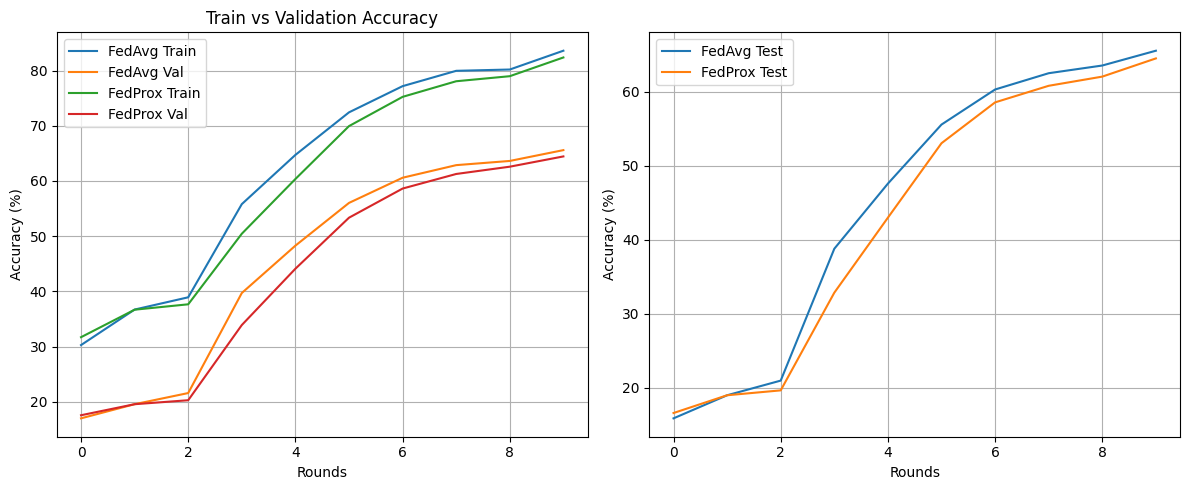

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import random
import matplotlib.pyplot as plt

# 1. Load MNIST
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return trainset, testset

# 2. Non-IID Partition
# Each client gets only two digits

def make_noniid_by_label(dataset, num_clients=10, num_labels_per_client=2):
    labels = np.array(dataset.targets)
    indices = np.arange(len(dataset))
    client_indices = [[] for _ in range(num_clients)]

    label_indices = {l: np.where(labels == l)[0] for l in range(10)}
    for l in label_indices:
        np.random.shuffle(label_indices[l])

    for client in range(num_clients):
        chosen_labels = np.random.choice(range(10), num_labels_per_client, replace=False)
        for l in chosen_labels:
            part = int(len(label_indices[l]) / num_clients)
            client_indices[client].extend(label_indices[l][:part])
            label_indices[l] = label_indices[l][part:]
    return client_indices

# 3. CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)

# 4. Client Class (FedAvg & FedProx)
class Client:
    def __init__(self, global_model, indices, device, dataset, batch_size=32):
        self.device = device
        self.model = CNN().to(device)
        self.model.load_state_dict(global_model.state_dict())
        self.loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=True)

    def local_train(self, global_weights, epochs=1, lr=0.01, mu=0.1, use_fedprox=False):
        optimizer = optim.SGD(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        global_params = {k: v.clone().detach() for k, v in global_weights.items()}

        self.model.train()
        for _ in range(epochs):
            for data, target in self.loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)

                if use_fedprox:
                    prox_reg = 0.0
                    for name, param in self.model.named_parameters():
                        prox_reg += ((param - global_params[name])**2).sum()
                    loss += (mu/2) * prox_reg

                loss.backward()
                optimizer.step()

        return self.model.state_dict()

# 5. Federated Averaging
def fedavg(local_states):
    new_state = {}
    for k in local_states[0].keys():
        new_state[k] = sum(state[k] for state in local_states) / len(local_states)
    return new_state

# 6. Evaluation
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

# 7. Main Training Loop
def run_federated(num_clients=5, rounds=10, local_epochs=1, lr=0.01, mu=0.1,
                  algorithm='fedprox', batch_size=32, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainset, testset = load_mnist()

    client_idx_lists = make_noniid_by_label(trainset, num_clients)

    # Split validation set from test set
    val_size = len(testset) // 2
    valset, testset_real = torch.utils.data.random_split(testset, [val_size, len(testset) - val_size])
    val_loader = DataLoader(valset, batch_size=256, shuffle=False)
    test_loader = DataLoader(testset_real, batch_size=256, shuffle=False)

    global_model = CNN().to(device)

    history = {"train": [], "val": [], "test": []}
    for r in range(rounds):
        local_states = []
        client_train_loaders = []

        for i in range(num_clients):
            client = Client(global_model, client_idx_lists[i], device, trainset, batch_size=batch_size)
            client_train_loaders.append(client.loader)
            use_fedprox = (algorithm.lower() == 'fedprox')
            local_w = client.local_train(global_model.state_dict(), epochs=local_epochs, lr=lr,
                                         mu=mu, use_fedprox=use_fedprox)
            local_states.append(local_w)

        # aggregate
        new_global = fedavg(local_states)
        global_model.load_state_dict(new_global)

        # evaluate train acc
        train_accs = []
        for loader in client_train_loaders:
            acc = evaluate(global_model, loader, device)
            train_accs.append(acc)
        train_acc = np.mean(train_accs)

        val_acc = evaluate(global_model, val_loader, device)
        test_acc = evaluate(global_model, test_loader, device)

        history["train"].append(train_acc)
        history["val"].append(val_acc)
        history["test"].append(test_acc)

        print(f"{algorithm.upper()} Round {r+1}/{rounds} - "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return history

# -----------------------------
# 8. Run FedAvg and FedProx
# -----------------------------
fedavg_hist = run_federated(num_clients=5, rounds=10, local_epochs=2, lr=0.01, mu=0.1, algorithm='fedavg')
fedprox_hist = run_federated(num_clients=5, rounds=10, local_epochs=2, lr=0.01, mu=0.1, algorithm='fedprox')

# 9. Plot Results
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fedavg_hist["train"], label='FedAvg Train')
plt.plot(fedavg_hist["val"], label='FedAvg Val')
plt.plot(fedprox_hist["train"], label='FedProx Train')
plt.plot(fedprox_hist["val"], label='FedProx Val')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(fedavg_hist["test"], label='FedAvg Test')
plt.plot(fedprox_hist["test"], label='FedProx Test')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
#plt.title("Test Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
